In [2]:
from langchain_community.utilities import SQLDatabase
from langchain_google_vertexai import ChatVertexAI
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
import re
from tabulate import tabulate 
import matplotlib.pyplot as plt
import uuid

# Used for LangGraph
from typing import TypedDict, Annotated, List, Dict, Any
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [3]:
project_id = 'eikon-dev-data-team'
dataset_id = "ancoldbdufanlive"

In [4]:
# --- 1. Define the State for the Graph ---
# This dictionary will hold the data that moves between the nodes of our graph.
class State(TypedDict):
    question: str
    query: str
    result: str
    structured_result: List[Dict[str, Any]]
    insight: str
    answer: str

In [5]:
db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")
db.get_table_info()

/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(


'\nCREATE TABLE `tc_ticketing` (\n\t`NO_TRANSAKSI` STRING OPTIONS(description=\'String representing the transaction number associated with the ticket.\'), \n\t`NO_TIKET` INT64 OPTIONS(description=\'Integer representing the ticket number.\'), \n\t`ID_SHIFT` STRING OPTIONS(description=\'String identifying the shift during which the ticket was used.\'), \n\t`ID_GATE` STRING OPTIONS(description=\'String identifying the gate where the ticket was used.\'), \n\t`TGL_INISIALISASI` DATE OPTIONS(description=\'Date when the ticket was initialized.\'), \n\t`SERI_TIKET` STRING OPTIONS(description=\'String representing the ticket series.\'), \n\t`NO_TIKET_REAL` INT64 OPTIONS(description=\'Integer representing the real or actual ticket number.\'), \n\t`STATUS_TIKET` INT64 OPTIONS(description=\'Integer representing the current status of the ticket.\'), \n\t`DESCRIPTION_BTL` STRING OPTIONS(description=\'String providing a description of the cancellation, if applicable.\'), \n\t`SUPERVISOR_BTL` STRING O

In [6]:
# --- 2. Define the Nodes for the Graph ---

def write_query(state: State):
    """Generates a SQL query from the user's question."""
    print("---GENERATING SQL QUERY---")
    question = state["question"]
    
    # This part is the same as before, but wrapped in a node function
    llm = ChatVertexAI(model="gemini-2.5-pro")
    
    template = """
    Based on the table schema below, write a SQL query that would answer the user's question.
    Pay attention to use only the column names that you can see in the schema description.
    Be careful to not query for columns that do not exist.
    Pay attention to which column is in which table.
    
    Do not make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

    Table Schema: {schema}
    Question: {question}
    SQL Query:
    """
    prompt = PromptTemplate.from_template(template)
    
    db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")

    def get_schema(_):
        return db.get_table_info()

    sql_query_chain = (
        RunnablePassthrough.assign(schema=get_schema)
        | prompt
        | llm.bind(stop=["\nSQLResult:"])
        | StrOutputParser()
    )

    generated_query = sql_query_chain.invoke({"question": question})
    
    # Clean up the generated query
    clean_query = generated_query.replace("```sql", "").replace("```", "").strip()
    
    return {"query": clean_query}

def check_query(state: State):
    """Validates the SQL query for common mistakes."""
    print("---CHECKING SQL QUERY---")
    query = state["query"]
    llm = ChatVertexAI(model="gemini-2.5-pro")
    db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")

    system = """Double check the user's {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query.
If there are no mistakes, just reproduce the original query with no further commentary.

Output the final SQL query only."""
    prompt = ChatPromptTemplate.from_messages(
        [("system", system), ("human", "{query}")]
    ).partial(dialect=db.dialect)
    
    validation_chain = prompt | llm | StrOutputParser()
    
    validated_query_text = validation_chain.invoke({"query": query})

    clean_validated_query = validated_query_text.replace("```sql", "").replace("```", "").strip()

    return {"query": clean_validated_query}

def execute_query(state: State):
    """Executes the SQL query and gets the result."""
    print("---EXECUTING SQL QUERY---")
    query = state["query"]
    db = SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")
    
    # Use _execute to get structured results
    query_result_dicts = db._execute(query, fetch="all")

    # **NEW:** Format and print the result as a table
    if query_result_dicts:
        headers = query_result_dicts[0].keys()
        data = [list(row.values()) for row in query_result_dicts]
        print("\n--- QUERY RESULT ---")
        print(tabulate(data, headers=headers, tablefmt="grid"))
        print("--------------------\n")
    else:
        print("\n--- QUERY RESULT ---")
        print("Query returned no results.")
        print("--------------------\n")

    # Convert result to string for downstream nodes
    query_result_str = str(query_result_dicts)
    
    return {"result": query_result_str}

def generate_chart(state: State):
    """Generates a bar chart from the query result and saves it to a file."""
    print("---GENERATING CHART---")
    data = state.get("structured_result", [])

    if not data or len(data) < 1 or len(data[0].keys()) < 2:
        print("Query result is not suitable for a chart. Skipping chart generation.")
        return

    try:
        headers = list(data[0].keys())
        # Assume the first column is the label (x-axis) and the second is the value (y-axis)
        labels = [row[headers[0]] for row in data]
        values = [row[headers[1]] for row in data]

        plt.figure(figsize=(10, 6))
        plt.bar(labels, values)
        plt.xlabel(headers[0])
        plt.ylabel(headers[1])
        plt.title(f"Chart of {headers[1]} by {headers[0]}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        chart_filename = "chart.png"
        plt.savefig(chart_filename)
        print(f"Chart successfully generated and saved as '{chart_filename}'")
        plt.close() # Close the plot to free up memory

    except Exception as e:
        print(f"Could not generate chart: {e}")

    # This node doesn't need to modify the state, it just performs an action.
    return {}

def generate_insight(state: State):
    """Generates insight from the SQL query and its result."""
    print("---GENERATING INSIGHT---")
    query = state["query"]
    result = state["result"]
    
    llm = ChatVertexAI(model="gemini-2.5-pro")

    insight_prompt = PromptTemplate.from_template(
        """
        You are a data analyst. Given the following SQL query and its result,
        provide a brief, one-sentence insight into what the data reveals.

        SQL Query: {query}
        SQL Result: {result}
        Insight:
        """
    )

    insight_chain = insight_prompt | llm
    insight_text = insight_chain.invoke(
        {"query": query, "result": result}
    )
    
    return {"insight": insight_text.content}

def generate_answer(state: State):
    """Generates a natural language answer from the SQL query result and insight."""
    print("---GENERATING FINAL ANSWER---")
    question = state["question"]
    result = state["result"]
    insight = state["insight"]
    
    llm = ChatVertexAI(model="gemini-2.5-pro")

    answer_prompt = PromptTemplate.from_template(
        """
        Given the user's question and the data insight, provide a final answer.

        Question: {question}
        Insight: {insight}
        Data Result (for context): {result}
        Final Answer:
        """
    )

    answer_chain = answer_prompt | llm
    final_answer = answer_chain.invoke(
        {"question": question, "insight": insight, "result": result}
    )
    
    return {"answer": final_answer.content}

In [7]:
# --- 3. Build and Compile the Graph ---

# This sets up the memory for our graph, allowing it to be paused and resumed.
memory = MemorySaver()

# Define the graph structure
graph_builder = StateGraph(State)

# Add the nodes
graph_builder.add_node("write_query", write_query)
graph_builder.add_node("check_query", check_query) # New validation node
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_chart", generate_chart)
graph_builder.add_node("generate_insight", generate_insight)
graph_builder.add_node("generate_answer", generate_answer)

# Define the edges (the flow of control)
graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "check_query")
graph_builder.add_edge("check_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_chart")
graph_builder.add_edge("generate_chart", "generate_insight")
graph_builder.add_edge("generate_insight", "generate_answer")
graph_builder.add_edge("generate_answer", END)

# Compile the graph, setting the interruption point
# The graph will pause *before* executing the 'execute_query' node.
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["execute_query"]
)

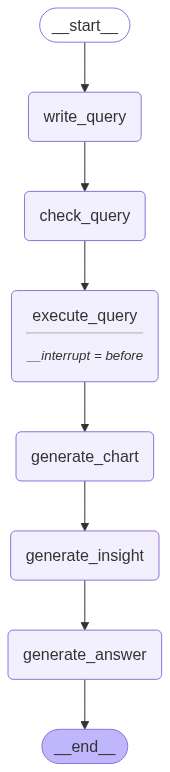

In [8]:
graph

In [9]:
def bigquery_qa_with_human_approval(p_id: str, d_id: str, q: str):
    """
    Runs the BigQuery Q&A process with a human approval step.
    """
    global project_id, dataset_id
    project_id = p_id
    dataset_id = d_id
    
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}}
    
    initial_state = {"question": q}
    
    for step in graph.stream(initial_state, config, stream_mode="values"):
        print(step)
    
    current_state = graph.get_state(config)
    generated_query = current_state.values.get("query")
    print("\n--- PENDING SQL QUERY ---")
    print(generated_query)
    print("-------------------------\n")

    try:
        user_approval = input("Do you want to execute this query? (yes/no): ")
    except Exception:
        user_approval = "no"

    if user_approval.lower() == "yes":
        print("\n--- QUERY APPROVED ---")
        for step in graph.stream(None, config, stream_mode="values"):
            print(step)
    else:
        print("\n--- QUERY DENIED ---")
        print("Operation cancelled by user.")

In [12]:
project_id = project_id  # Replace with your project ID
dataset_id = dataset_id  # Replace with your dataset ID
question = "Berapa penjualan tiket per hari bulan februari 2014?"  

bigquery_qa_with_human_approval(project_id, dataset_id, question)

{'question': 'Berapa penjualan tiket per hari bulan februari 2014?'}
---GENERATING SQL QUERY---


/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(


{'question': 'Berapa penjualan tiket per hari bulan februari 2014?', 'query': 'SELECT\n  CAST(TGL_TRANSAKSI AS DATE) AS tanggal_transaksi,\n  SUM(TTL_BAYAR) AS total_penjualan\nFROM tt_tiketing\nWHERE\n  EXTRACT(YEAR FROM TGL_TRANSAKSI) = 2014\n  AND EXTRACT(MONTH FROM TGL_TRANSAKSI) = 2\nGROUP BY\n  tanggal_transaksi\nORDER BY\n  tanggal_transaksi;'}
---CHECKING SQL QUERY---


/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(


{'question': 'Berapa penjualan tiket per hari bulan februari 2014?', 'query': 'SELECT\n  CAST(TGL_TRANSAKSI AS DATE) AS tanggal_transaksi,\n  SUM(TTL_BAYAR) AS total_penjualan\nFROM tt_tiketing\nWHERE\n  EXTRACT(YEAR FROM TGL_TRANSAKSI) = 2014\n  AND EXTRACT(MONTH FROM TGL_TRANSAKSI) = 2\nGROUP BY\n  tanggal_transaksi\nORDER BY\n  tanggal_transaksi;'}

--- PENDING SQL QUERY ---
SELECT
  CAST(TGL_TRANSAKSI AS DATE) AS tanggal_transaksi,
  SUM(TTL_BAYAR) AS total_penjualan
FROM tt_tiketing
WHERE
  EXTRACT(YEAR FROM TGL_TRANSAKSI) = 2014
  AND EXTRACT(MONTH FROM TGL_TRANSAKSI) = 2
GROUP BY
  tanggal_transaksi
ORDER BY
  tanggal_transaksi;
-------------------------


--- QUERY APPROVED ---
{'question': 'Berapa penjualan tiket per hari bulan februari 2014?', 'query': 'SELECT\n  CAST(TGL_TRANSAKSI AS DATE) AS tanggal_transaksi,\n  SUM(TTL_BAYAR) AS total_penjualan\nFROM tt_tiketing\nWHERE\n  EXTRACT(YEAR FROM TGL_TRANSAKSI) = 2014\n  AND EXTRACT(MONTH FROM TGL_TRANSAKSI) = 2\nGROUP BY\n  tan

/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(



--- QUERY RESULT ---
+---------------------+-------------------+
| tanggal_transaksi   |   total_penjualan |
+=====================+===================+
| 2014-02-01          |       7.97788e+08 |
+---------------------+-------------------+
| 2014-02-02          |       5.54325e+08 |
+---------------------+-------------------+
| 2014-02-03          |       2.10506e+08 |
+---------------------+-------------------+
| 2014-02-04          |       1.2934e+08  |
+---------------------+-------------------+
| 2014-02-05          |       8.9058e+07  |
+---------------------+-------------------+
| 2014-02-06          |       1.32038e+08 |
+---------------------+-------------------+
| 2014-02-07          |       1.31912e+08 |
+---------------------+-------------------+
| 2014-02-08          |       3.323e+08   |
+---------------------+-------------------+
| 2014-02-09          |       4.7015e+08  |
+---------------------+-------------------+
| 2014-02-10          |       1.6512e+08  |
+---------

---

# With PGVector

In [1]:
from langchain_community.utilities import SQLDatabase
from langchain_google_vertexai import ChatVertexAI, VertexAIEmbeddings
# from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.prompts import PromptTemplate, ChatPromptTemplate, FewShotPromptTemplate
from langchain_core.tools import tool
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain.schema.runnable import RunnablePassthrough
from langchain_postgres import PGVector
from langchain_core.documents import Document
import pandas as pd
import uuid
import os
import io
import matplotlib.pyplot as plt
from dotenv import load_dotenv
# Used for LangGraph
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [2]:
from PIL import Image

load_dotenv() 

True

In [3]:
os.environ["GOOGLE_CLOUD_PROJECT"] = os.environ.get("GOOGLE_CLOUD_PROJECT")
os.environ["GOOGLE_CLOUD_LOCATION"] = os.environ.get("GOOGLE_CLOUD_LOCATION")
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = os.environ.get("GOOGLE_GENAI_USE_VERTEXAI")

In [4]:
project_id = 'eikon-dev-data-team'
dataset_id = "ancoldbdufanlive"

In [5]:
class State(TypedDict):
    question: str
    query: str
    structured_result: List[Dict[str, Any]] # To hold structured data for charts/tables
    insight: str
    answer: str
    chart_image: bytes | None # To hold the chart image in memory
    chart_code: str | None # To hold the Python code for the chart
    chart_type: str | None # To hold the chosen chart type
    visualization_reason: str | None # To hold the reason for the chart choice
    log: List[str] # To hold the processing steps
    error: str | None # To hold error messages for the conditional edge
    retry_count: int # To prevent infinite loops

In [6]:
def get_llm():
    return ChatVertexAI(model=os.environ.get("LLM_MODEL_NAME"))

def get_db(project_id, dataset_id):
    return SQLDatabase.from_uri(f"bigquery://{project_id}/{dataset_id}")


In [7]:
# --- Dynamic Few-Shot Examples Setup ---
examples = [
    {
        "question": "berapa jumlah tiket yang terjual tiap tahunnya dari tahun 2012-2015?",
        "query": "SELECT EXTRACT(YEAR FROM TGL_TRANSAKSI) AS transaction_year, SUM(JML_TIKET_BYR + JML_TIKET_GRATIS) AS total_tickets_sold FROM `tt_tiketing` WHERE EXTRACT(YEAR FROM TGL_TRANSAKSI) BETWEEN 2012 AND 2015 GROUP BY transaction_year ORDER BY transaction_year;"
    },
    {
        "question": "berapa penjualan tiket per hari di bulan maret 2013?",
        "query": "SELECT FORMAT_DATE('%Y-%m-%d', DATE(TGL_TRANSAKSI)) AS sales_date, SUM(JML_TIKET_BYR) AS total_paid_tickets_sold FROM `tt_tiketing` WHERE EXTRACT(YEAR FROM TGL_TRANSAKSI) = 2013 AND EXTRACT(MONTH FROM TGL_TRANSAKSI) = 3 GROUP BY sales_date ORDER BY sales_date;"
    },
    {
        "question": "buatkan analisa pendapatan tiket dunia fantasi dari tahun 2012-2014",
        "query": "SELECT EXTRACT(YEAR FROM TGL_TRANSAKSI) AS tahun_transaksi,SUM(TTL_BAYAR) AS total_pendapatan FROM tt_tiketing WHERE EXTRACT(YEAR FROM TGL_TRANSAKSI) BETWEEN 2012 AND 2014 GROUP BY tahun_transaksi ORDER BY tahun_transaksi;"
    },
]

In [8]:
def get_example_selector():
    # --- PGVector Connection ---
    db_user = os.environ.get("POSTGRES_USER")
    db_password = os.environ.get("POSTGRES_PASSWORD")
    db_host = os.environ.get("POSTGRES_LOCALHOST")
    db_port = os.environ.get("POSTGRES_PORT")
    db_name = os.environ.get("POSTGRES_DB")

    if not all([db_user, db_password, db_host, db_port, db_name]):
        print(
            "Database connection variables are not fully set. "
            "Please create a `.env` file with `POSTGRES_USER`, `POSTGRES_PASSWORD`, "
            "`POSTGRES_HOST`, `POSTGRES_PORT`, and `POSTGRES_DB`."
        )
        
    CONNECTION_STRING = f"postgresql+psycopg://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
    COLLECTION_NAME = "sql_examples_v3" # Changed version to avoid conflicts

    embeddings = VertexAIEmbeddings(model=os.environ.get("EMBEDDING_MODEL_NAME"))
    # embeddings = GoogleGenerativeAIEmbeddings(model=os.environ.get("EMBEDDING_MODEL_NAME"))
    
    # Create Document objects for PGVector. The question is the content to be searched against.
    documents = [
        Document(
            page_content=ex["question"],
            metadata=ex  # Store the full example dict in metadata
        ) for ex in examples
    ]
    
    try:
        # Initialize PGVector. This will create the collection and embed the documents
        # if it's the first time, or connect to the existing collection.
        vectorstore = PGVector.from_documents(
            documents=documents,
            embedding=embeddings,
            collection_name=COLLECTION_NAME,
            connection=CONNECTION_STRING,
            pre_delete_collection=True # Start fresh during development
        )
    except Exception as e:
        print(f"Failed to connect to or initialize PGVector. Please check your connection string and database setup. Error: {e}")
    # The selector will use the PGVector store for similarity searches
    example_selector = SemanticSimilarityExampleSelector(
        vectorstore=vectorstore,
        k=5,
    )

    # This prompt formats each selected example before it's added to the main prompt
    example_prompt = PromptTemplate.from_template("User input: {question}\nSQL query: {query}")
    
    return example_selector, example_prompt

In [9]:
def write_query(state: State):
    """Generates a SQL query from the user's question using dynamic few-shot examples."""
    log = state.get("log", [])
    log.append("✍️ Generating SQL query...")
    question = state["question"]
    
    llm = get_llm()
    db = get_db(project_id, dataset_id)
    
    example_selector, example_prompt = get_example_selector()

    few_shot_prompt = FewShotPromptTemplate(
        example_selector=example_selector,
        example_prompt=example_prompt,
        prefix="You are a Google BigQuery SQL expert. Given an input question, create a syntactically correct Google BigQuery query to run.\n\nHere is the relevant table info: {schema}\n\nBelow are a number of examples of questions and their corresponding SQL queries.",
        suffix="User input: {question}\nSQL query: ",
        input_variables=["question", "schema"],
    )

    def get_schema(_):
        return db.get_table_info()

    sql_query_chain = (
        RunnablePassthrough.assign(schema=get_schema)
        | few_shot_prompt
        | llm.bind(stop=["\nSQLResult:"])
        | StrOutputParser()
    )

    generated_query = sql_query_chain.invoke({"question": question})
    clean_query = generated_query.replace("```sql", "").replace("```", "").strip()
    
    return {"query": clean_query, "log": log}

In [10]:
def execute_query(state: State):
    """Executes the SQL query and gets the result."""
    log = state.get("log", [])
    log.append("🚀 Executing SQL query...")
    query = state["query"]

    db = get_db(project_id, dataset_id)
    
    try:
        query_result_dicts = db._execute(query, fetch="all")
        return {"structured_result": query_result_dicts, "log": log, "error": None}
    except Exception as e:
        error_message = f"Query execution failed: {e}"
        return {"structured_result": [], "log": log + [error_message], "error": error_message}


In [11]:
def rewrite_query_on_error(state: State):
    """Takes the failed query and error, and asks the LLM to rewrite it."""
    log = state.get("log", [])
    log.append("🔧 Query failed. Attempting to fix...")
    
    query = state["query"]
    error = state["error"]
    retry_count = state.get("retry_count", 0)

    if retry_count >= 5: # Limit retries
        log.append("❌ Reached max retries. Stopping.")
        return {"log": log}

    llm = get_llm()
    
    rewrite_prompt = PromptTemplate.from_template(
        """
        You are a Google BigQuery SQL expert. The following SQL query failed with an error.
        Your task is to analyze the query and the error message, and rewrite the query to fix the issue.
        Pay close attention to the error message as it contains crucial clues.
        
        **CRITICAL BIGQUERY RULES FOR DATES AND TIMESTAMPS:**
        1.  `TIMESTAMP_SUB` **CANNOT** be used with `YEAR`, `QUARTER`, or `MONTH`. It will cause an error.
        2.  To subtract years or months from a `TIMESTAMP` column, you **MUST** cast the column to a `DATE` first and use `DATE_SUB`.
            - **Correct Example:** `WHERE DATE(t.TGL_TRANSAKSI) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 YEAR)`
            - **Incorrect Example:** `WHERE t.TGL_TRANSAKSI >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 3 YEAR)`

        Original Failed Query:
        {query}

        Error Message:
        {error}

        Corrected Google BigQuery SQL Query:
        """
    )
    rewriter_chain = rewrite_prompt | llm | StrOutputParser()
    corrected_query = rewriter_chain.invoke({"query": query, "error": error})
    clean_corrected_query = corrected_query.replace("```sql", "").replace("```", "").strip()

    return {
        "query": clean_corrected_query, 
        "log": log, 
        "error": None, # Clear the error for the next attempt
        "retry_count": retry_count + 1
    }

In [12]:
def generate_chart_with_choice(state: State):
    """Single LLM call: choose chart type, columns, and generate chart code & image."""
    log = state.get("log", [])
    log.append("🤖 Choosing chart type & generating visualization in one step...")

    structured_result = state.get("structured_result")
    if not structured_result or len(structured_result) < 2:
        log.append("No chart generated (not enough data).")
        return {"chart_type": "table", "chart_image": None, "chart_code": None, "log": log}

    df = pd.DataFrame(structured_result)
    column_info = f"Columns: {', '.join(df.columns)}\nData Types:\n{df.dtypes.to_string()}"
    first_few_rows = df.head(3).to_string()

    llm = get_llm()

    chart_prompt = PromptTemplate.from_template(
        """
        You are a Python data visualization expert. 
        Based on the data and the user's question, do the following in one response:

        1. **Choose chart type**: Decide between 'bar', 'line', 'pie', 'scatter', or 'table'.
        2. **Pick columns**: Select the most appropriate `x_col` and `y_col`.  
           - For pie: x_col = labels, y_col = values.
           - If no chart is suitable, use 'table'.
        3. **Explain reasoning**: Brief one-sentence reason.
        4. **Generate Python code**:  
           - Use `df` directly (already defined). DO NOT simulate or create data.  
           - Use matplotlib (and seaborn if useful).  
           - Apply chosen chart type, with x_col on x-axis, y_col on y-axis.  
           - Add title, labels, legend (if needed).  
           - Use `plt.tight_layout()`.  
           - Save image to buffer with:
             ```python
             buf = io.BytesIO(); plt.savefig(buf, format='png'); buf.seek(0)
             ```

        User's Question: {question}

        Data Information:
        {column_info}

        Sample Data:
        {first_few_rows}

        Return JSON ONLY in the following format:
        {{
          "chart_type": "<bar|line|pie|scatter|table>",
          "x_col": "<column_name or null>",
          "y_col": "<column_name or null>",
          "reason": "<short reason>",
          "code": "<valid Python code string>"
        }}
        """
    )

    parser = JsonOutputParser()
    chart_chain = chart_prompt | llm | parser

    try:
        result = chart_chain.invoke({
            "question": state["question"],
            "column_info": column_info,
            "first_few_rows": first_few_rows
        })

        chart_type = result.get("chart_type", "table")
        chart_code = result.get("code", "")

        if chart_type == "table":
            log.append("No suitable chart. Returning table view.")
            return {"chart_type": "table", "chart_image": None, "chart_code": None, "log": log}

        # Clean and execute code
        chart_code = chart_code.replace("```python", "").replace("```", "").strip()

        buf = io.BytesIO()
        local_vars = {"df": df, "io": io, "plt": plt, "pd": pd}
        exec(chart_code, {}, local_vars)
        buf = local_vars.get("buf", None)
        chart_image = buf.getvalue() if buf else None

        log.append(f"✅ Chart generated successfully: {chart_type} - {result.get('reason')}")
        return {
            "chart_type": chart_type,
            "x_col": result.get("x_col"),
            "y_col": result.get("y_col"),
            "visualization_reason": result.get("reason"),
            "chart_image": chart_image,
            "chart_code": chart_code,
            "log": log
        }

    except Exception as e:
        log.append(f"⚠️ Failed: {e}")
        return {"chart_type": "table", "chart_image": None, "chart_code": None, "log": log}

In [13]:
def generate_insight(state: State):
    """Generates insight from the SQL query and its result."""
    log = state.get("log", [])
    log.append("💡 Generating insight...")
    query = state["query"]
    
    if not state.get("structured_result"):
        return {"insight": "No data was returned from the query.", "log": log}
    
    structured_result = state["structured_result"]
    result_str = str(structured_result)

    llm = get_llm()
    insight_prompt = PromptTemplate.from_template(
        """
        You are a data analyst. Given the following SQL query and its result,
        provide a brief, one or two-sentence insight into what the data reveals.
        Focus on the most important finding.

        SQL Query: {query}
        SQL Result: {result}
        Insight:
        """
    )
    insight_chain = insight_prompt | llm | StrOutputParser()
    insight_text = insight_chain.invoke({"query": query, "result": result_str})
    return {"insight": insight_text, "log": log}

def should_continue(state: State):
    """Determines the next step after query execution based on whether an error occurred."""
    if state.get("error"):
        if state.get("retry_count", 0) >= 2:
            return "end"
        return "rewrite_query_on_error"
    else:
        return "generate_chart_with_choice"

In [14]:
def get_graph():
    graph_builder = StateGraph(State)
    graph_builder.add_node("write_query", write_query)
    graph_builder.add_node("execute_query", execute_query)
    graph_builder.add_node("rewrite_query_on_error", rewrite_query_on_error)
    graph_builder.add_node("generate_chart_with_choice", generate_chart_with_choice)
    graph_builder.add_node("generate_insight", generate_insight)

    graph_builder.add_edge(START, "write_query")
    graph_builder.add_edge("write_query", "execute_query")
    
    graph_builder.add_conditional_edges(
        "execute_query",
        should_continue,
        {
            "rewrite_query_on_error": "rewrite_query_on_error",
            "generate_chart_with_choice": "generate_chart_with_choice",
            "end": END
        }
    )

    graph_builder.add_edge("rewrite_query_on_error", "execute_query")
    graph_builder.add_edge("rewrite_query_on_error", "execute_query")
    graph_builder.add_edge("generate_chart_with_choice", "generate_insight")
    graph_builder.add_edge("generate_insight", END)
    
    return graph_builder.compile()

🚀 Starting analysis for question: 'berapa penjualan tiket per hari di bulan juni 2015?'


/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_SELESAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column 'JAM_MULAI'
  sqlalchemy.util.warn(
/home/luay9/.venv/lib/python3.12/site-packages/sqlalchemy_bigquery/_types.py:101: SAWarning: Did not recognize type 'INTERVAL' of column



--- 📊 Final Results ---
❓ Question: berapa penjualan tiket per hari di bulan juni 2015?
💡 Insight: Daily ticket sales in June 2015 fluctuate significantly, with the highest sales consistently occurring on weekends (e.g., June 13-14, June 27-28) and notably lower sales on various weekdays. This suggests a strong weekend peak in ticket purchasing activity.
 SQL Query: 
SELECT
    FORMAT_DATE('%Y-%m-%d', DATE(TGL_TRANSAKSI)) AS sales_date,
    SUM(JML_TIKET_BYR) AS total_paid_tickets_sold
  FROM
    `tt_tiketing`
  WHERE
    EXTRACT(YEAR FROM TGL_TRANSAKSI) = 2015
    AND EXTRACT(MONTH FROM TGL_TRANSAKSI) = 6
  GROUP BY
    sales_date
  ORDER BY
    sales_date
📈 Chart Generated: Yes
✅ Chart saved as 'chart_output.png'

--- 📝 Execution Log ---
✍️ Generating SQL query...
🚀 Executing SQL query...
🤖 Choosing chart type & generating visualization in one step...
✅ Chart generated successfully: line - A line chart is best to visualize daily sales trends over a specific period.
💡 Generating ins

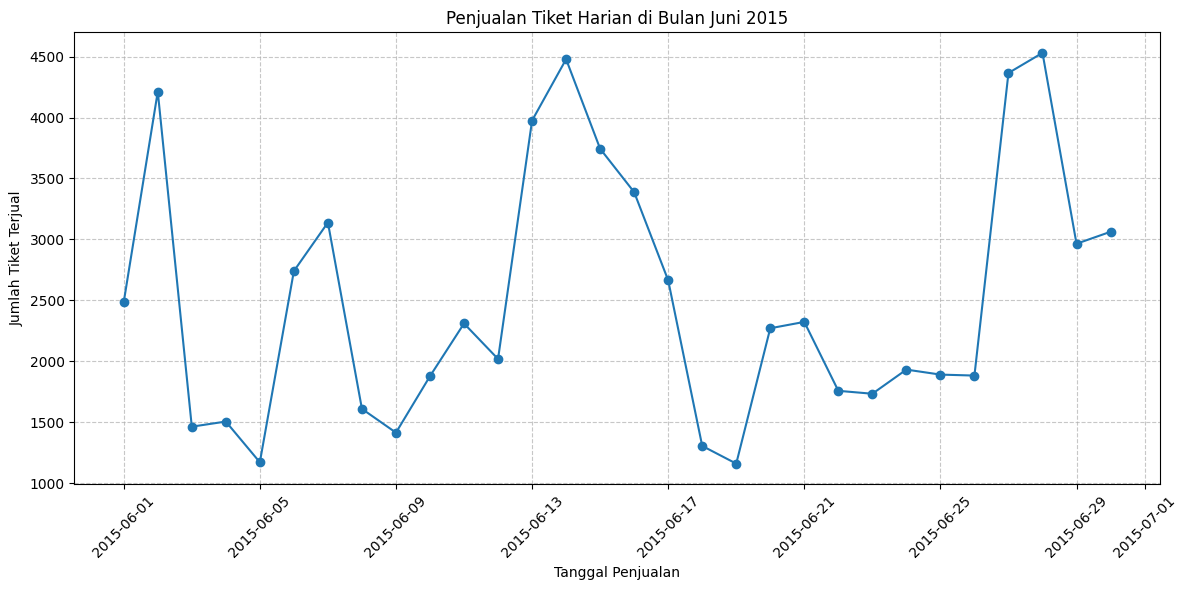

In [15]:
app = get_graph()

question = "berapa penjualan tiket per hari di bulan juni 2015?"

    # --- 3. Set the initial state ---
initial_state: State = {
    "question": question,
    "query": "",
    "structured_result": [],
    "insight": "",
    "answer": "",
    "chart_image": None,
    "chart_code": None,
    "chart_type": None,
    "visualization_reason": None,
    "log": [],
    "error": None,
    "retry_count": 0,
}

# --- 4. Invoke the graph ---
print(f"🚀 Starting analysis for question: '{question}'")
final_state = app.invoke(initial_state)

# --- 5. Display the results ---
print("\n\n--- 📊 Final Results ---")
print(f"❓ Question: {final_state['question']}")
print(f"💡 Insight: {final_state['insight']}")
print(f" SQL Query: \n{final_state['query']}")

if final_state.get('chart_image'):
    print("📈 Chart Generated: Yes")
    
    # Save the chart image to a file
    try:
        image_bytes = final_state['chart_image']
        image = Image.open(io.BytesIO(image_bytes))
        chart_filename = "chart_output.png"
        image.save(chart_filename)
        print(f"✅ Chart saved as '{chart_filename}'")
    except Exception as e:
        print(f"Could not save chart image: {e}")
        
else:
    print("📈 Chart Generated: No (Result will be in table format)")
    print("\nStructured Result (Table Data):")
    if final_state.get('structured_result'):
        import pandas as pd
        df = pd.DataFrame(final_state['structured_result'])
        print(df.to_string())
    else:
        print("No data returned.")

print("\n--- 📝 Execution Log ---")
for log_entry in final_state['log']:
    print(log_entry)